In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stabl.stabl import Stabl, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features, plot_roc, boxplot_binary_predictions
from stabl.adaptive import ALasso, ALogitLasso
from stabl import data

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet

%config InlineBackend.figure_formats=['retina'] 

In [2]:
random_state = 42

lasso = Lasso(max_iter=int(1e6), random_state=random_state)
logit_lasso = LogisticRegression(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", random_state=random_state)

alasso = ALasso(max_iter=int(1e6), random_state=random_state)
alogit_lasso = ALogitLasso(penalty="l1", max_iter=int(1e6), solver="liblinear", class_weight="balanced", random_state=random_state)

en = ElasticNet(max_iter=int(1e6), random_state=random_state)
logit_en = LogisticRegression(penalty="elasticnet", max_iter=int(1e6), solver="saga", class_weight="balanced", random_state=random_state)

In [3]:
# We use the built in function to load data
X_train_ool, X_valid_ool, y_train_ool, y_valid_ool, ids_ool, task_type_ool = data.load_onset_of_labor_cv("Sample Data/Onset of Labor")

preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),  # Removing 0 variance features
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
        ("imputer", SimpleImputer(strategy="median")),  # Imputing missing values with median
        ("std", StandardScaler())  # Z-scoring features
    ]
)

## Random Forest

In [15]:
X_train_ool, X_valid_ool, y_train_ool, y_valid_ool, ids_ool, task_type_ool = data.load_onset_of_labor_cv("Sample Data/Onset of Labor")

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=random_state)

grid = {'max_depth': [3, 4, 5]}

stabl_regression = Stabl(
    base_estimator=clone(rf),
    lambda_grid=grid,
    artificial_type="knockoff",
    artificial_proportion=1,
    n_bootstraps=50,
    random_state=random_state,
    verbose=1,
)

prot_std = pd.DataFrame(
    data=preprocessing.fit_transform(X_train_ool["Proteomics"]),
    index=X_train_ool["Proteomics"].index,
    columns=preprocessing.get_feature_names_out()
)

prot_std = prot_std.iloc[:300, :]
y_train_ool = y_train_ool.iloc[:300]

In [16]:
stabl_regression.fit(prot_std, y_train_ool)

Stabl progress:   0%|          | 0/3 [00:00<?, ?it/s]

Stabl(artificial_proportion=1, artificial_type='knockoff',
      base_estimator=RandomForestRegressor(random_state=42),
      fdr_threshold_range=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
      lambda_grid={'max_depth': [3, 4, 5]}, n_bootstraps=50, random_state=42,
      verbose=1)

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Threshold'>)

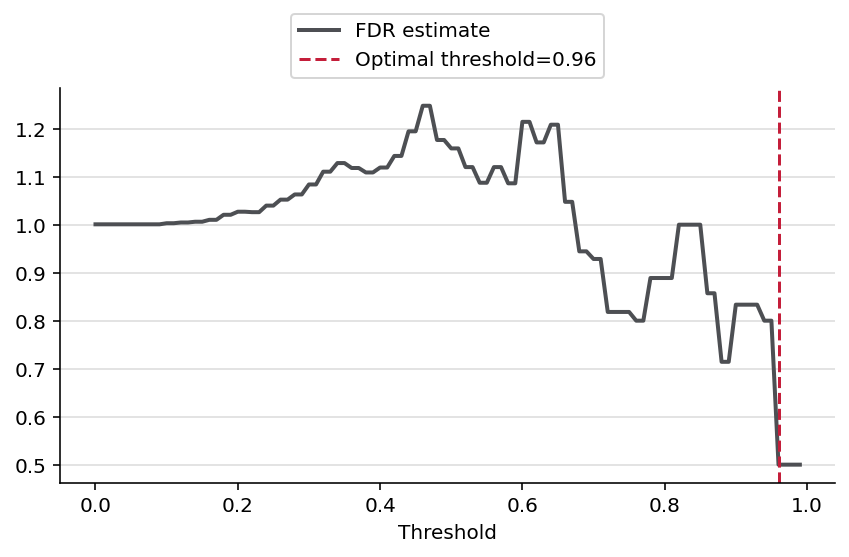

In [17]:
plot_fdr_graph(stabl_regression, figsize=(6, 4))

C'est 1 !
Les paramètres sont max_depth ! :-)


(<Figure size 288x576 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>,
 [0.6, 0.8, 1.0],
 [0, 1, 2])

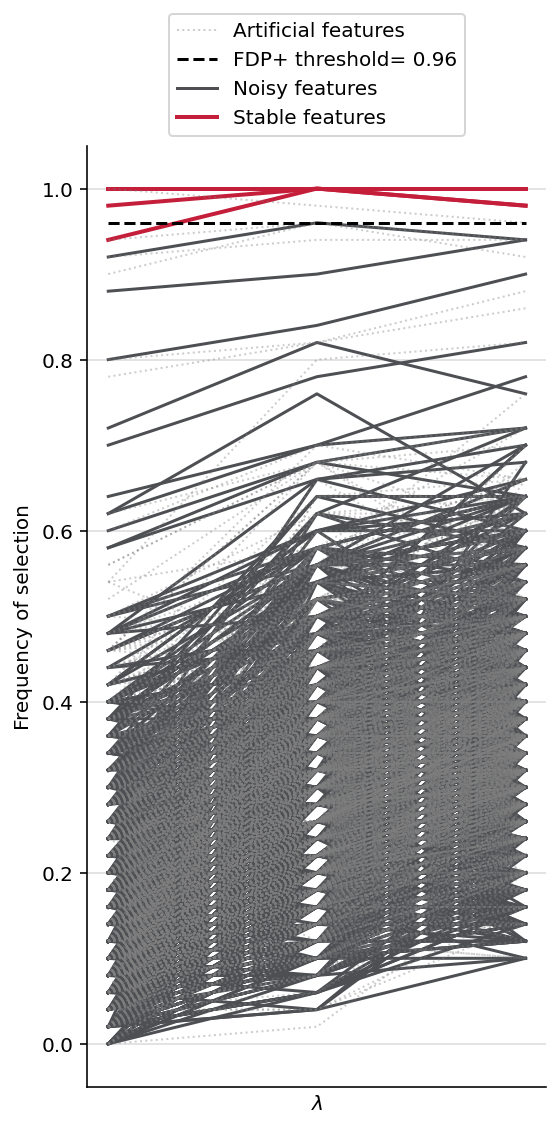

In [18]:
plot_stabl_path(stabl_regression, figsize=(4,8))

In [20]:
stabl_regression.get_feature_names_out()

array(['Siglec.6', 'Activin.A', 'IL.1.R4', 'PLXB2'], dtype=object)

## XGBoost

In [10]:
X_train_ool, X_valid_ool, y_train_ool, y_valid_ool, ids_ool, task_type_ool = data.load_onset_of_labor_cv("Sample Data/Onset of Labor")

from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, random_state=random_state)

grid = {'max_depth': [3, 5], 'reg_lambda': [0.1, 1]}

stabl_regression = Stabl(
    base_estimator=clone(xgb),
    lambda_grid=grid,
    artificial_type="knockoff",
    artificial_proportion=1,
    n_bootstraps=50,
    random_state=random_state,
    verbose=1,
)

prot_std = pd.DataFrame(
    data=preprocessing.fit_transform(X_train_ool["Proteomics"]),
    index=X_train_ool["Proteomics"].index,
    columns=preprocessing.get_feature_names_out()
)

prot_std = prot_std.iloc[:300, :]
y_train_ool = y_train_ool.iloc[:300]

In [11]:
stabl_regression.fit(prot_std, y_train_ool)

Stabl progress:   0%|          | 0/4 [00:00<?, ?it/s]

Stabl(artificial_proportion=1, artificial_type='knockoff',
      base_estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                                  colsample_bylevel=None, colsample_bynode=None,
                                  colsample_bytree=None, device=None,
                                  early_stopping_rounds=None,
                                  enable_categorical=False, eval_metric=None,
                                  feature_types=None, gamma=None,
                                  grow_policy=None, importance_type=None,
                                  inter...
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
      lambda_grid={'max_depth': [3, 5], 'reg_lambda': [0.1, 1]},
      n_bootstraps=50, random_state=42, verbose=1)

(<Figure size 432x288 with 1 Axes>, <Axes: xlabel='Threshold'>)

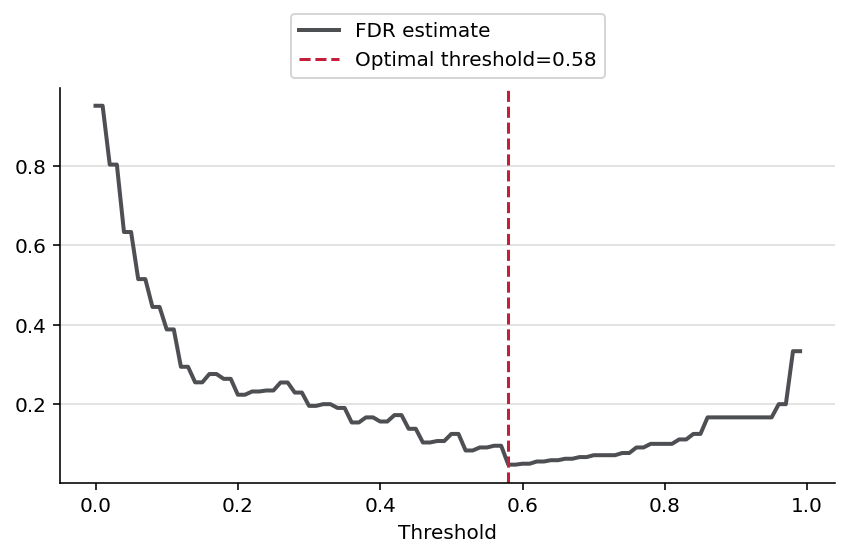

In [12]:
plot_fdr_graph(stabl_regression, figsize=(6, 4))

(<Figure size 576x576 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>,
 [1.00001, 1.90001, 1.90002, 2.80002],
 [0, 1, 2, 3])

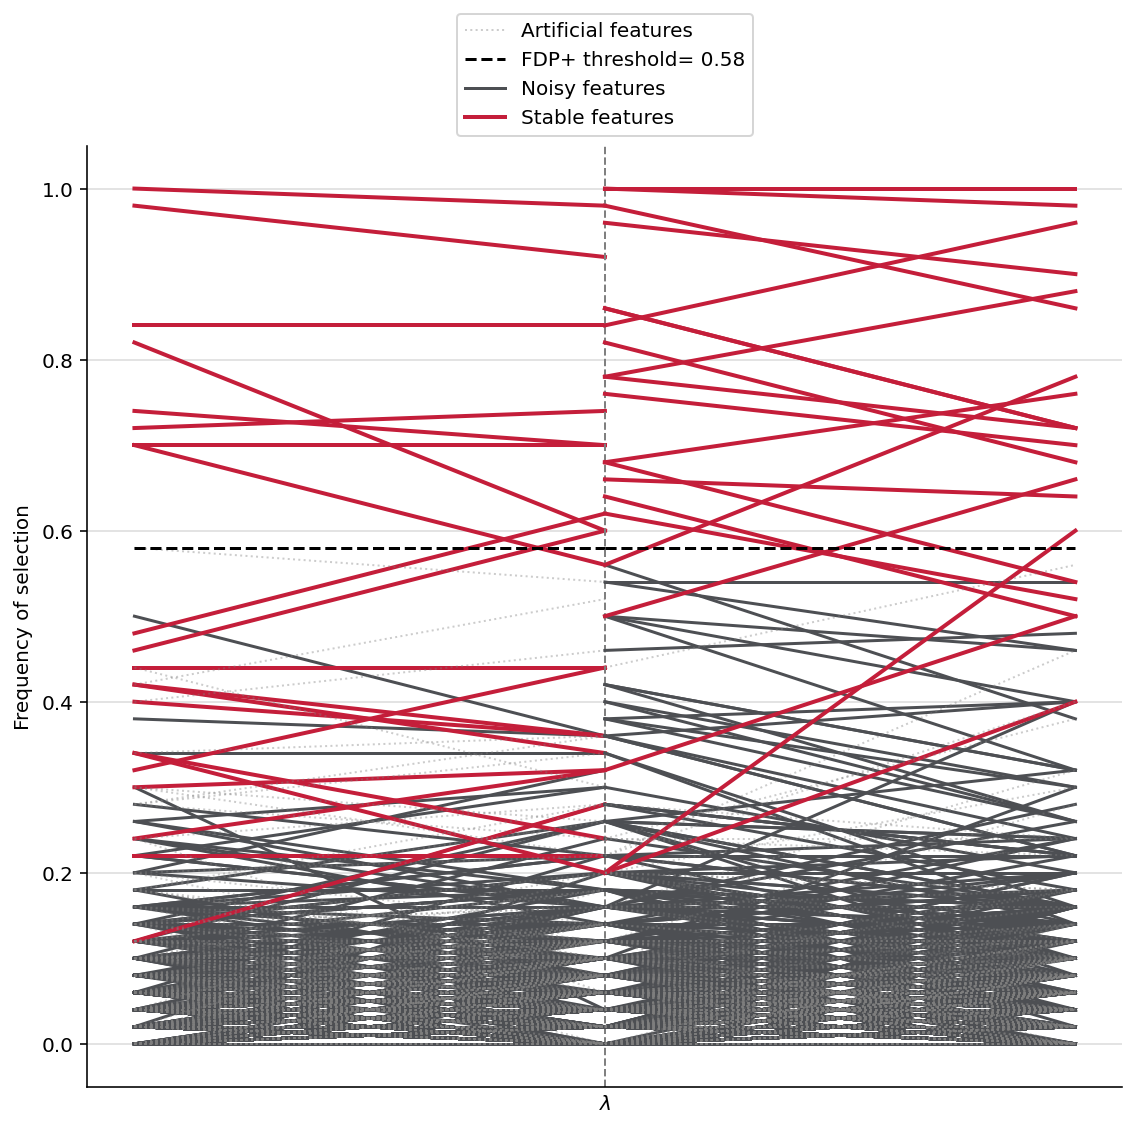

In [13]:
plot_stabl_path(stabl_regression, figsize=(4,8))

In [ ]:
stabl_regression.get_feature_names_out()

array(['Siglec.6', 'Activin.A', 'IL.1.R4', 'PLXB2'], dtype=object)